An autoencoder is a type of unsupervised learning method. More than that, it is a type of 'generative' model which once trained can potentially help generate synthetic data. In essense, it is a non-linear dimensionality reduction technique to learn the internal low-dimensional structure of the data.

An autoencoder model contains two components:

**1. An encoder:** that takes an image as input, and outputs a low-dimensional embedding (representation) of the image.

**2. A decoder:** that takes the low-dimensional embedding, and reconstructs the image.


![](./images/autoencoder_schematic.png "Image courtesy: Hackernoon article on Autoencoder")

In esence autoencoder can be viewed as a dimensionality reduction tool for embedding the data in low-dimensional latent space which is non-linear. 

**Relationship to PCA**

Autoencoder can be seen as a generalisation of principal component analysis to nonlinear manifolds. If we remove the nonlinearity (brought about by the activation functions) then the result of autoencoder will be in (some sense) equivalent to PCA. Now, however, the component vectors encoded by weights will not be orthogonal, like with PCA.

**Anamoly Detection**

Besides being used a generative model, it can be used as a anamoly detection method by considering the loss value between the decoded object and the encoded entity. By setting a threshold on the acceptable loss values we can train the model to flag any instances wherein the model's loss value exceed that limit and potentially is an anamolous digit. 

Such an anamoly detection could be used in processes where images, sound, or signal is scanned and flagged for being out of spec. Google I/O in 2021 had a nice workshop on introducing Autoencoder and their utility in anomaly detection for detecting abnormal heart rhythm. [Video](https://www.youtube.com/watch?v=2K3ScZp1dXQ) 


A simple autoencoder based on a CNN architecture will be built to encode and embed MNIST hand-written digit data. 

**Model Development**

For the CNN stride and filter size is chose to ensure final vector in the bottleneck is commensurate with a single vector. To understand more on the how the stride and filter is chosen, or the effect of those parameters on the convolution, there's a helpful visualization and documentation here: https://github.com/vdumoulin/conv_arithmetic 

In [1]:
import os 
import copy 
import numpy as np 

import torch 
import torch.nn as nn 
import tqdm.notebook as tqdm
import torch.nn.functional as F
torch.manual_seed(42);
np.random.seed(42);

In [2]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [3]:
plot_params = {
'image.cmap':'binary',
'image.interpolation':'nearest'
}
 
plt.rcParams.update(plot_params)

In [4]:
from torchvision import datasets, transforms

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
transform_data = transforms.ToTensor()

train_dataset = datasets.MNIST(root='input/',
                           train=True,
                           transform=transform_data,
                           download=True)
val_dataset = datasets.MNIST(root='input/',
                            train=False,
                            transform=transform_data,
                            download=True)

In [7]:
input_tensor, label = train_dataset[0]
print('MNIST dataset with {} train data and {} validation data'.format(len(train_dataset), len(val_dataset)))
print('Type of data in dataset: {} AND {}'.format(type(input_tensor), type(label)))
print('Input tensor image dimensions: {}'.format(input_tensor.shape))

MNIST dataset with 60000 train data and 10000 validation data
Type of data in dataset: <class 'torch.Tensor'> AND <class 'int'>
Input tensor image dimensions: torch.Size([1, 28, 28])


In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dimensions=10):
        super(AutoEncoder, self).__init__()
        
        self.encoder_module = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7, stride=1, padding=0)
            )
        
        self.decoder_module = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        self.NN_encode_to_latent = nn.Linear(64,latent_dimensions)
        self.NN_latent_to_decode = nn.Linear(latent_dimensions,64)
        
    def encoder(self, x):
        #Encode the points 
        encode_x = self.encoder_module(x)
        batch_size, _, _, _ = encode_x.shape
        
        #Bottle neck layer - dont need this but useful when converting it to variational type
        encode_x = encode_x.view(batch_size, -1)
        
        x_encode_to_latent = self.NN_encode_to_latent(encode_x)
        
        return(x_encode_to_latent, batch_size)
    
    def decoder(self, x_encode_to_latent, batch_size):
        x_latent_to_decode = self.NN_latent_to_decode(x_encode_to_latent)
        
        # Decode the points 
        latent_x_reshape = x_latent_to_decode.view(batch_size, -1, 1, 1)
        reconst = self.decoder_module(latent_x_reshape)
        
        return(reconst)
        
    def forward(self, x):
        latent_vector, batch_size = self.encoder(x)
        reconst = self.decoder(latent_vector, batch_size)
        return(reconst, latent_vector)    

In [9]:
def train(model, data_loader, epoch, criterion, optimizer): 
    counter = 0
    epoch_loss_list = []
    model.train()
    
    for i, data_batch in enumerate(data_loader):

        data, label = data_batch 
        data = data.to(device)

        reconstruction, latent_x = model(data)

        loss = criterion(reconstruction, data)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        counter = counter + 1 
        epoch_loss_list.append(loss.item())
        
        if i == 0: #Only append first batch 
            outputs = (epoch, label, data.cpu().detach(), latent_x, reconstruction.cpu().detach())
    
    mean_train_loss = sum(epoch_loss_list) / counter 
    
    if epoch % 5 == 0:  
        print('Training: Epoch: {0}, Loss: {1:0.3f}'.format(epoch+1, mean_train_loss))
    

    return outputs, epoch_loss_list, mean_train_loss 

def validation(model, data_loader, epoch, criterion):    
    counter = 0
    epoch_loss_list = []
    model.eval()
    for i, data_batch in enumerate(data_loader):
        with torch.no_grad():
            data, label = data_batch 
            data = data.to(device)

            reconstruction, latent_x = model(data)

            loss = criterion(reconstruction, data)
            
            counter = counter + 1 
            epoch_loss_list.append(loss.item())
            
        if i == 0: #Only append first batch 
            outputs = (epoch, label, data.cpu().detach(), latent_x, reconstruction.cpu().detach())
    
    mean_val_loss = sum(epoch_loss_list) / counter
    
    if epoch % 5 == 0:        
        print('** Validation: Epoch: {0}, Loss: {1:0.3f}'.format(epoch+1, mean_val_loss))
        print('-'*10)


    return outputs, epoch_loss_list, mean_val_loss

In [10]:
model = AutoEncoder(latent_dimensions=20)
model = model.to(device)    
model

AutoEncoder(
  (encoder_module): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder_module): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
  (NN_encode_to_latent): Linear(in_features=64, out_features=20, bias=True)
  (NN_latent_to_decode): Linear(in_features=20, out_features=64, bias=True)
)

In [11]:
num_epochs=20
batch_size=64
learning_rate=1e-3

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                            lr = learning_rate,
                            weight_decay=1e-5)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                          batch_size = batch_size,
                                          shuffle = True)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                          batch_size = batch_size,
                                          shuffle = True)

In [12]:
%%time
train_output_array, val_output_array = [], [] 
train_loss_array, val_loss_array = [], []

for epoch in tqdm.tqdm(range(num_epochs)):
    train_out, train_loss_list, epoch_train_loss = train(model, train_loader, epoch, criterion, optimizer)
    val_out, val_loss_list, epoch_val_loss = validation(model, val_loader, epoch, criterion)

    train_loss_array.append(epoch_train_loss)
    val_loss_array.append(epoch_val_loss)
    
    train_output_array.append(train_out)
    val_output_array.append(val_out)
    
    # Append loss values for train and validation in the final epoch
    # Another option is to taken loss values for the epoch when the validation loss is lowest 
    if epoch == num_epochs - 1:
        final_train_loss = train_loss_list
        final_val_loss = val_loss_list

  0%|          | 0/20 [00:00<?, ?it/s]

Training: Epoch: 1, Loss: 0.047
** Validation: Epoch: 1, Loss: 0.022
----------
Training: Epoch: 6, Loss: 0.009
** Validation: Epoch: 6, Loss: 0.008
----------
Training: Epoch: 11, Loss: 0.008
** Validation: Epoch: 11, Loss: 0.008
----------
Training: Epoch: 16, Loss: 0.008
** Validation: Epoch: 16, Loss: 0.008
----------
CPU times: user 4min 14s, sys: 3.15 s, total: 4min 17s
Wall time: 4min 17s


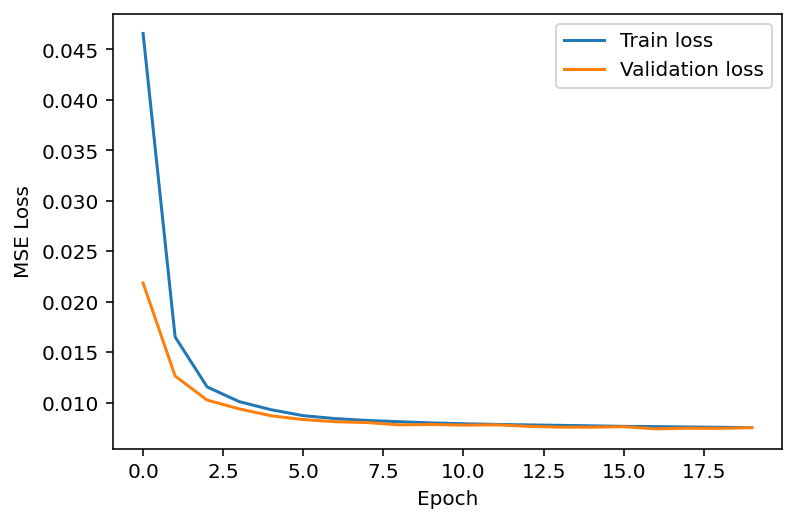

In [13]:
# Plot loss curve 
plt.plot(train_loss_array, label='Train loss')
plt.plot(val_loss_array, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend(loc='best');

In [14]:
len(train_output_array)

20

Epoch: 0


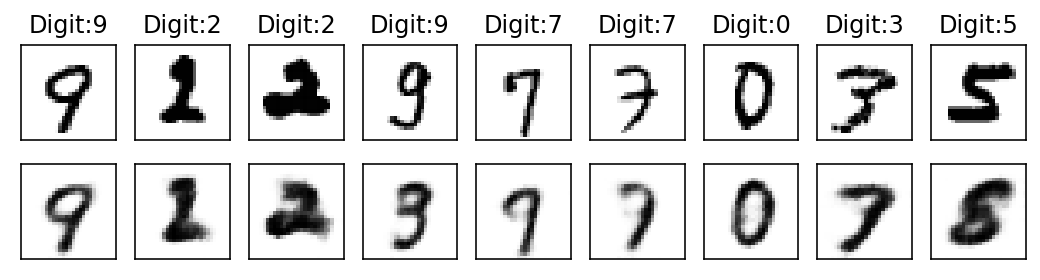

Epoch: 4


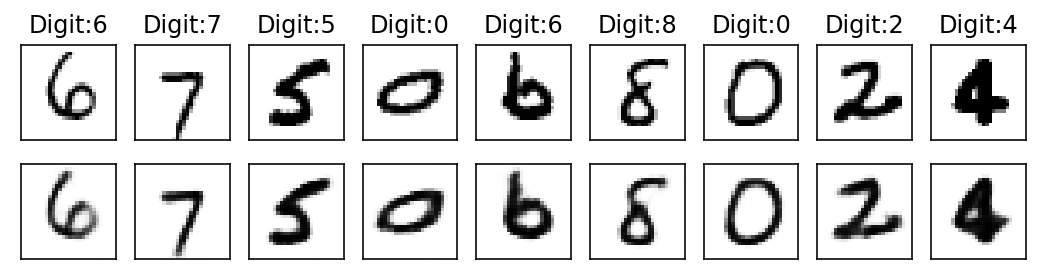

Epoch: 8


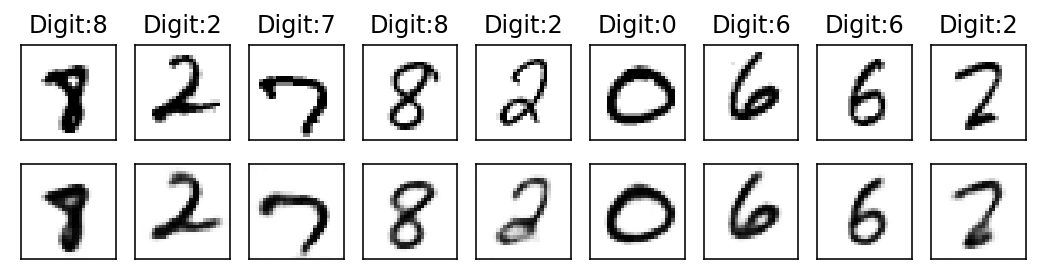

Epoch: 12


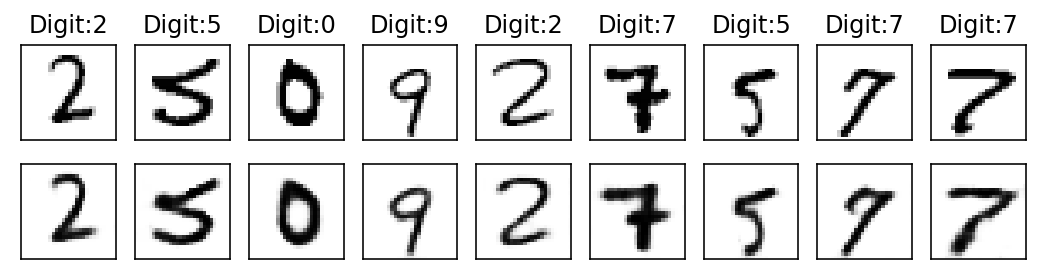

Epoch: 16


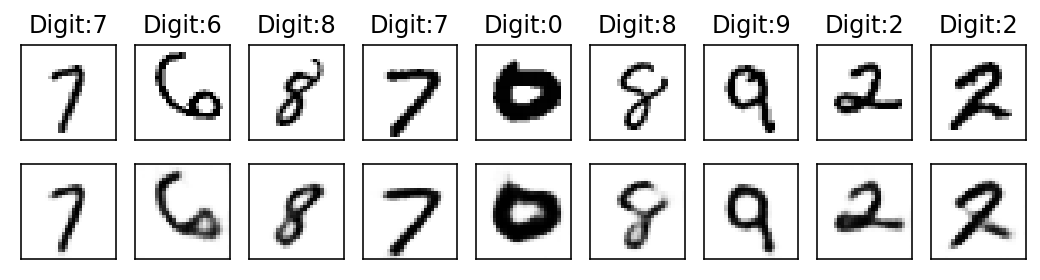

In [15]:
for k in range(0, num_epochs, 4):

    digit_out = val_output_array[k][2].detach().numpy()
    label_out = val_output_array[k][1].detach().numpy()
    reconst_out = val_output_array[k][4].detach().numpy()
    
    fig, ax = plt.subplots(2,9, figsize=(9,2))
    ax = ax.flatten()
    
    print('Epoch: {}'.format(k))
    for i, item in enumerate(digit_out):
        if i < 9:
            ax[i].imshow(item[0], cmap=cm.binary, interpolation='nearest')
            ax[i].set_title('Digit:{}'.format(label_out[i]))
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            
    for i, item in enumerate(reconst_out):
        if i < 9:
            ax[i+9].imshow(item[0], cmap=cm.binary, interpolation='nearest')
            ax[i+9].set_xticks([])
            ax[i+9].set_yticks([])
    plt.show()

With subsequent epochs the reconstruction of the images becomes better. 

In [16]:
img_temp = val_output_array[num_epochs-1][2].detach().numpy()

print(img_temp.shape)

model = model.cpu()

ecode_img, vector_img = model(torch.tensor(img_temp))


print(criterion(ecode_img, torch.tensor(img_temp)).item())

print(ecode_img.shape, vector_img.shape)

vector_img = vector_img.detach().numpy()
print(vector_img.shape)

ecode_img = ecode_img.detach().numpy()
print(ecode_img.shape)

(64, 1, 28, 28)
0.007447564974427223
torch.Size([64, 1, 28, 28]) torch.Size([64, 20])
(64, 20)
(64, 1, 28, 28)


Visualizing the reconstruction of a random validation data digit

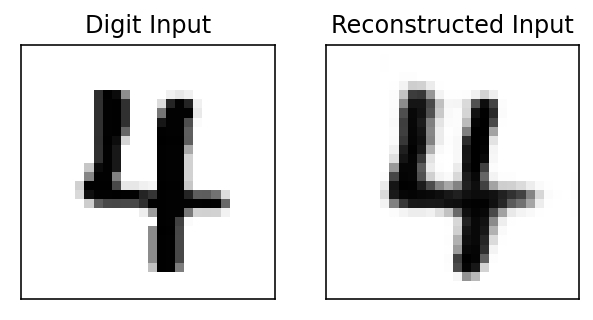

In [17]:
fig, ax = plt.subplots(1,2,figsize=(5,5))
ax[0].imshow(img_temp[0][0], cmap=cm.binary, interpolation='nearest')
ax[0].set_title('Digit Input')
ax[1].imshow(ecode_img[0][0], cmap=cm.binary, interpolation='nearest')
ax[1].set_title('Reconstructed Input')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].set_xticks([])
ax[1].set_yticks([]);

In [18]:
# Final loss values for each batch of train and validation set 
print(len(final_train_loss), len(final_val_loss))

938 157


Visualize the distribution of epoch losses for train and validation set from the last epoch. The statistics from this distribution will be used to set the `threshold` for the anamoly detection in the later section

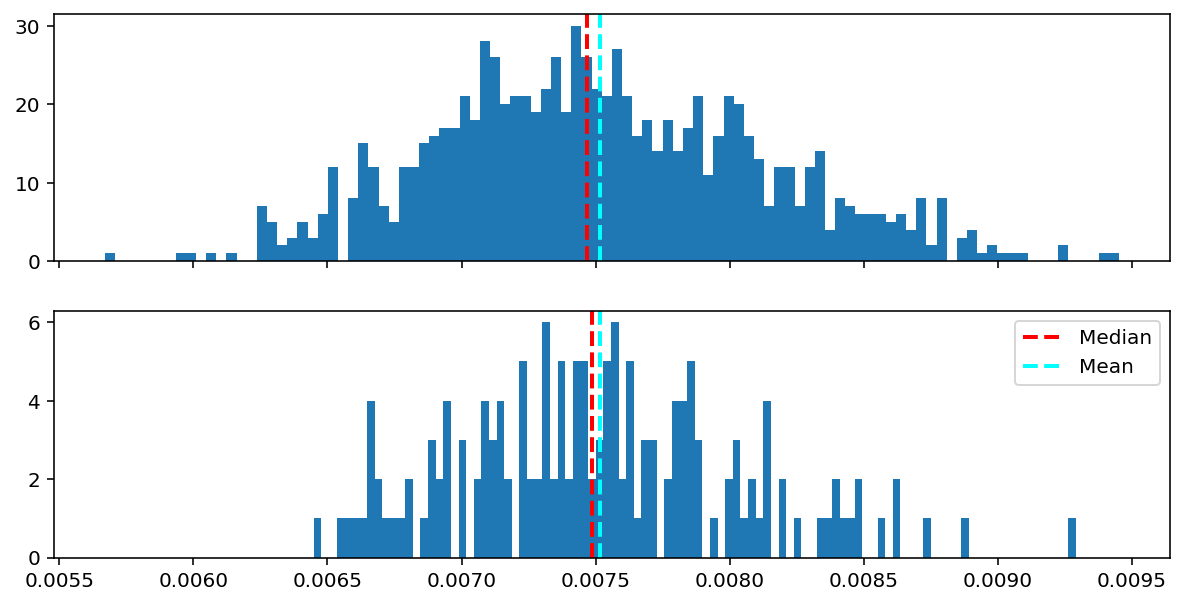

In [19]:
fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True)
ax[0].hist(final_train_loss, bins=100)
ax[0].axvline(x = np.median(final_train_loss), color='red', linestyle='--', linewidth=2.0, label='Median')
ax[0].axvline(x = np.mean(final_train_loss), color='cyan', linestyle='--', linewidth=2.0, label='Mean')

ax[1].hist(final_val_loss, bins=100)
ax[1].axvline(x = np.median(final_val_loss), color='red', linestyle='--', linewidth=2.0,label='Median')
ax[1].axvline(x = np.mean(final_val_loss), color='cyan', linestyle='--', linewidth=2.0,label='Mean')

plt.legend();

In [51]:
print('Mean Train Loss: {:0.6f}'.format(np.mean(final_train_loss)))
print('Mean Val Loss: {:0.6f}'.format(np.mean(final_val_loss)))

Mean Train Loss: 0.007515
Mean Val Loss: 0.007516


In [50]:
threshold_loss = np.mean(final_val_loss) + np.std(final_val_loss)
print('Threshold loss is set at: {:0.6f}'.format(threshold_loss))

Threshold loss is set at: 0.008046


## Visualize latent space

In [20]:
label_collection = np.array([])
latent_space_collection = np.zeros((0,20))
for i, data_batch in enumerate(val_loader):
    with torch.no_grad():
        data, label = data_batch 
        reconstruction, latent_x = model(data)
        label_collection = np.concatenate((label.numpy(), label_collection))
        latent_space_collection = np.vstack((latent_x.numpy(), latent_space_collection))

In [21]:
print(label_collection.shape, latent_space_collection.shape)

(10000,) (10000, 20)


### tSNE plots

In [22]:
import openTSNE as openTSNE
print('openTSNE', openTSNE.__version__)

openTSNE 0.6.0


In [23]:
%%time
# BH and PCA_init by default
Z1 = openTSNE.TSNE(n_jobs=-1, negative_gradient_method='bh').fit(latent_space_collection)

CPU times: user 2min 46s, sys: 2min 11s, total: 4min 57s
Wall time: 39 s


/depot/jgreeley/apps/envs/gpu_env1/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


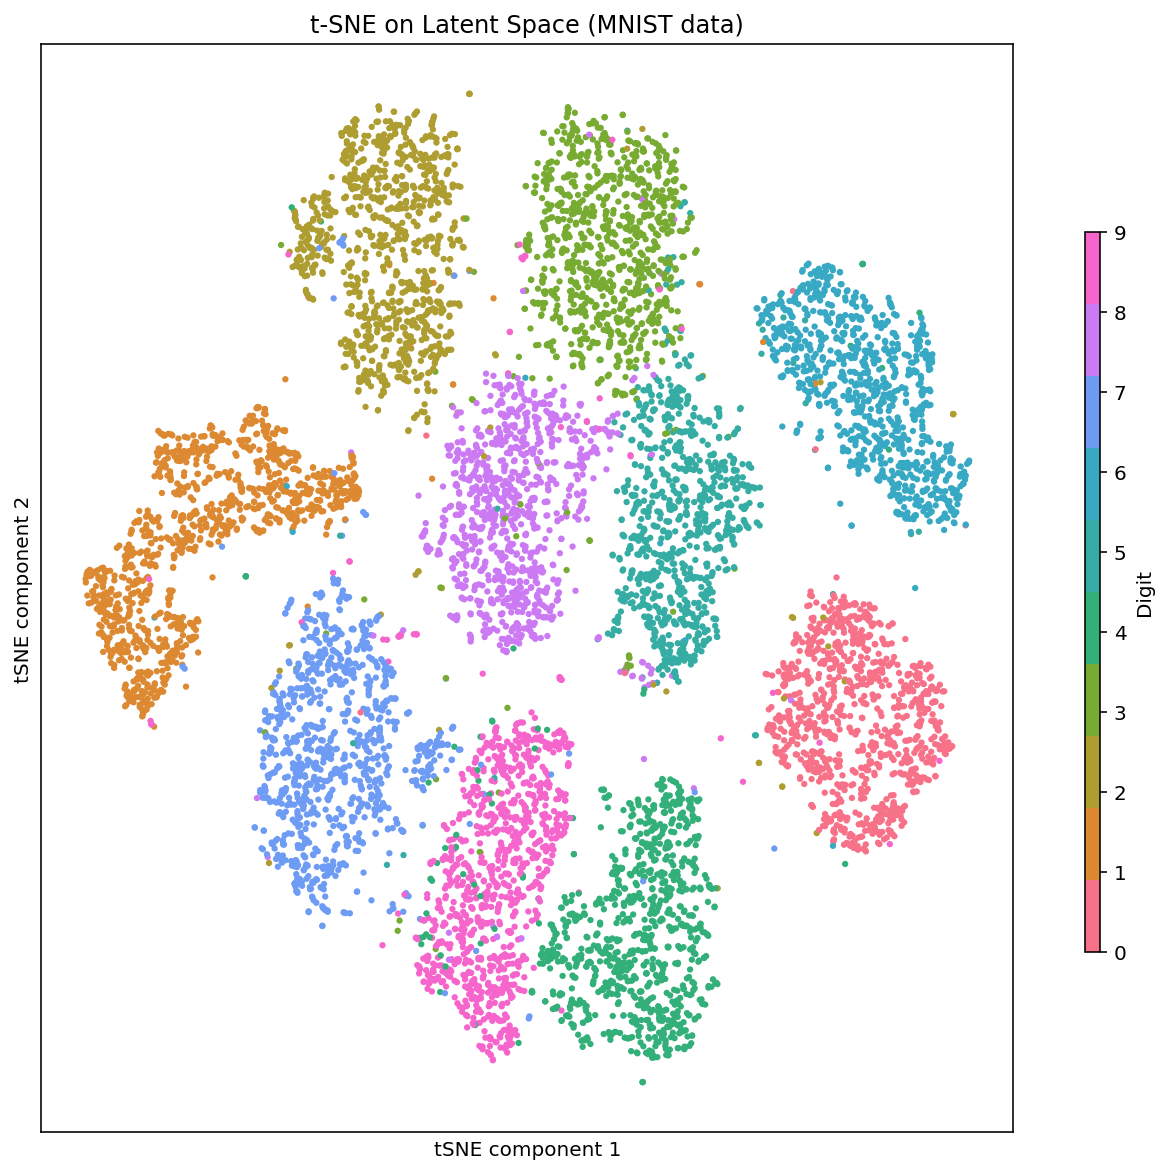

In [24]:
from matplotlib.colors import ListedColormap
import seaborn as sns
cmap = ListedColormap(sns.husl_palette(len(np.unique(label_collection))))

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.scatter(Z1[:,0], Z1[:,1], s=10, c=label_collection, cmap=cmap, edgecolor='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('tSNE component 1')
ax.set_ylabel('tSNE component 2')
ax.set_title('t-SNE on Latent Space (MNIST data)')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.01, 0.5], label='digit')
cbar = fig.colorbar(im, cax=cbar_ax, label='Digit')

Embedding 20 dimensions in 2 dimensional tSNE space, the clusters for each digit become quite clear. It is interesting to see that cluster for 1 and 7 are quite close to another, similarly cluster for 5 and 3 which have been traditionally challenging to distinguish in the classifers

## Linear interpolation in the latent space

In [25]:
print(latent_space_collection.shape)

#Select random points for start and ending 
start_point_index = 4121
end_point_index = 9832

start_point_latent_vectors = latent_space_collection[start_point_index]
end_point_latent_vectors = latent_space_collection[end_point_index]

(10000, 20)


In [26]:
num_steps = 10
trajectory_points = np.zeros((0,20))
for i in range(num_steps):
    z = start_point_latent_vectors * i/num_steps + end_point_latent_vectors * (num_steps - i) / num_steps 
    trajectory_points = np.vstack((z, trajectory_points))
    
print(trajectory_points.shape)

(10, 20)


In [27]:
trajectory_latent_tensor = torch.tensor(trajectory_points)

In [28]:
reconstruction_images = model.decoder(trajectory_latent_tensor.float(), trajectory_latent_tensor.shape[0])
reconstruction_images.shape

torch.Size([10, 1, 28, 28])

In [29]:
reconstruction_images = reconstruction_images.detach()

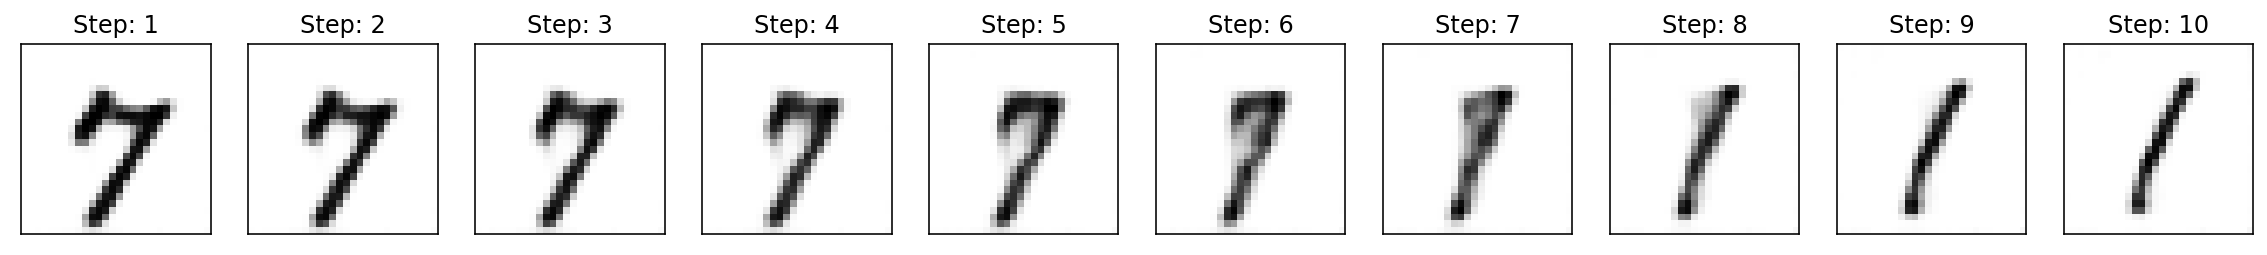

In [30]:
fig, ax = plt.subplots(1,num_steps, figsize=(num_steps+10,4))
ax = ax.flatten()

for i in range(0, reconstruction_images.shape[0]):
    ax[i].imshow(reconstruction_images[i][0], cmap=cm.binary, interpolation='nearest')
    ax[i].set_title('Step: {}'.format(i+1))
    ax[i].set_xticks([])
    ax[i].set_yticks([]);

Visualizing the image generated from each embedding iterated in a linear fashion from start to finish shows the transition between end points

## Denoising images

An autoencoder trained on cleaned image can be used to clear out blurry inputs from outside training set 

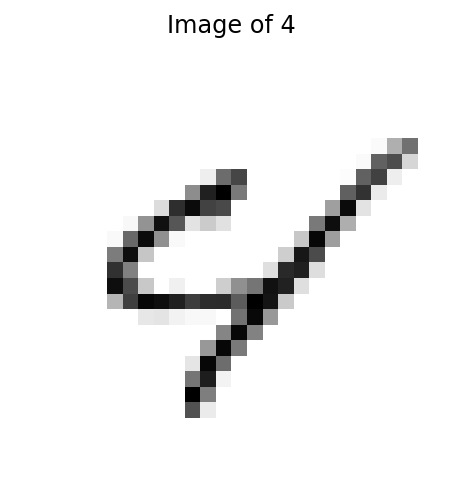

In [31]:
# Add artificial noise to a random image 
rand_idx = 420
digit_image, label = val_dataset[rand_idx]
digit_image = digit_image[0]

plt.imshow(digit_image)
plt.title('Image of {}'.format(label))
plt.axis('off');

Add gaussian noise to the image. Code taken from [Github](https://gist.github.com/Prasad9/28f6a2df8e8d463c6ddd040f4f6a028a#gistcomment-3322834)

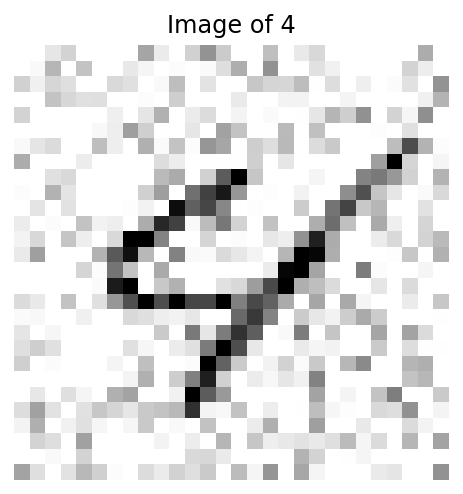

In [32]:
random_noise = np.random.randn(digit_image.shape[0], digit_image.shape[1])
digit_image_noise = np.clip( digit_image + random_noise * 0.2, 0, 1)
plt.imshow(digit_image_noise)
plt.title('Image of {}'.format(label))
plt.axis('off');

In [33]:
digit_input_tensor = torch.tensor(digit_image_noise[np.newaxis, np.newaxis, ...]).float();

/depot/jgreeley/apps/envs/gpu_env1/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [34]:
digit_input_tensor.shape

torch.Size([1, 1, 28, 28])

In [35]:
predicted_image, _ = model(digit_input_tensor)
predicted_image = predicted_image.detach().numpy()

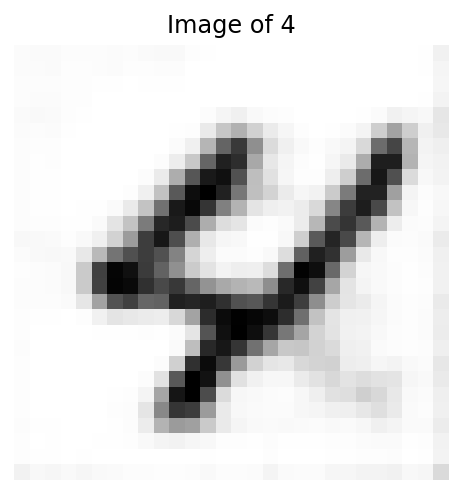

In [36]:
plt.imshow(predicted_image[0][0])
plt.title('Image of {}'.format(label))
plt.axis('off');

The results are much more useful in the case of variational autoencoder which is more robust to noise in the input data since the latent is less sparse due to the variational part

## Anomaly Detection 

In [37]:
def reconstruction_loss(input_image, _model=model, _criterion=criterion, plot=True):
    model = _model.cpu()
    input_image_tensor = torch.tensor(input_image)
    
    encoded_image, _ = model(input_image_tensor)
    
    loss_value = _criterion(encoded_image, input_image_tensor).item()
    
    encoded_image = encoded_image.detach().numpy()
    
    if plot == True:
        fig, ax = plt.subplots(1,3,figsize=(10,5))
        ax[0].imshow(input_image[0][0], cmap=cm.binary, interpolation='nearest')
        ax[0].set_title('Input Image')
        
        ax[1].imshow(encoded_image[0][0], cmap=cm.binary, interpolation='nearest')
        ax[1].set_title('Reconstructed Input')
        
        ax[2].imshow(input_image[0][0] - encoded_image[0][0], cmap=cm.binary, interpolation='nearest')
        ax[2].set_title('Image Difference')
        
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        
    return(loss_value)

In [38]:
random_entry_from_val_set = val_output_array[num_epochs-4][2].detach().numpy()[0]
print(random_entry_from_val_set.shape)

(1, 28, 28)


In [39]:
input_image = random_entry_from_val_set[np.newaxis, ...]
print(input_image.shape)

(1, 1, 28, 28)


Loss value is 0.001904 which is lower than set threshold, so this image is not an Anomaly


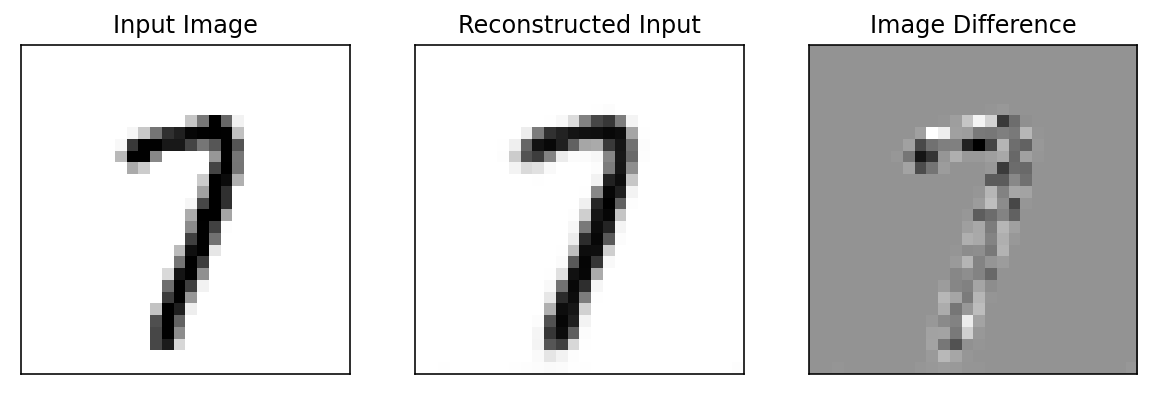

In [56]:
loss_value = reconstruction_loss(input_image)
compare_value = ('Higher' if loss_value > threshold_loss else 'lower')
anamoly_tag = ('anomaly' if compare_value == 'Higher' else 'not an Anomaly')
print('Loss value is {0:6f} which is {1} than set threshold, so this image is {2}'.format(loss_value, compare_value, anamoly_tag))

### Example

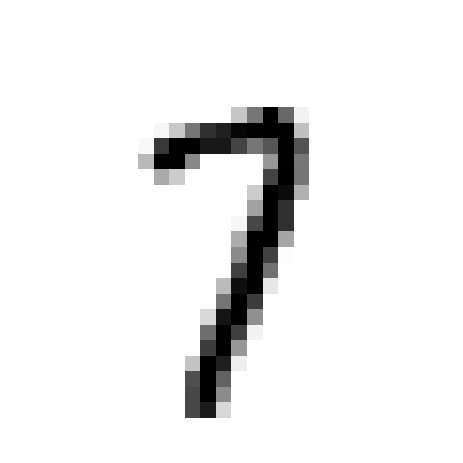

In [41]:
plt.imshow(input_image[0][0])
plt.axis('off');

In [42]:
# Rotate by 90: 
temp_image_rotate = np.rot90(input_image, k=1, axes=(2,3)).copy() # To get rid of negative stride error 

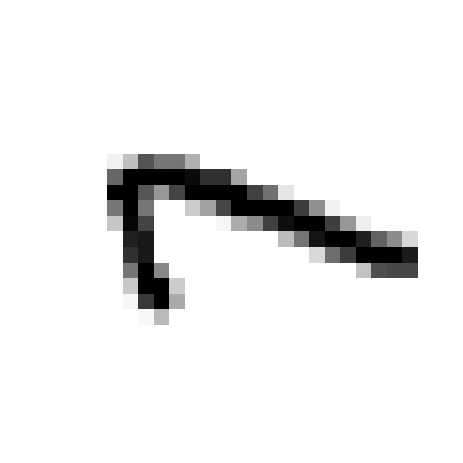

In [43]:
plt.imshow(temp_image_rotate[0][0])
plt.axis('off');

Loss value is 0.028646 which is Higher than set threshold, so this image is anomaly


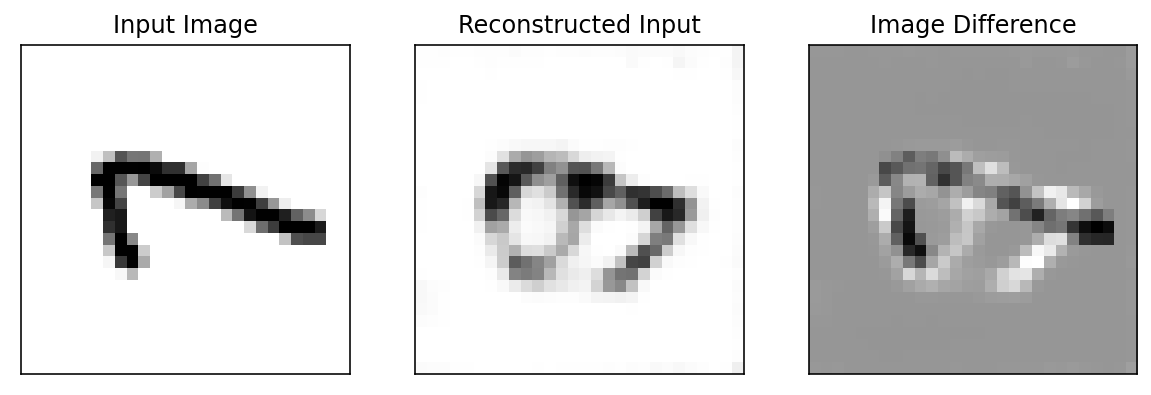

In [57]:
loss_value = reconstruction_loss(temp_image_rotate)
compare_value = ('Higher' if loss_value > threshold_loss else 'lower')
anamoly_tag = ('anomaly' if compare_value == 'Higher' else 'not an Anomaly')
print('Loss value is {0:6f} which is {1} than set threshold, so this image is {2}'.format(loss_value, compare_value, anamoly_tag))